In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math

class TSP():
    cities = 0
    distances = []
    locations = []
    
    def distance(self, c1, c2):
        loc1, loc2 = self.locations[c1], self.locations[c2]
        return math.sqrt((loc1[0]-loc2[0])**2 + (loc1[1]-loc2[1])**2)
    
    def __init__(self, cities, seed=1):
        random.seed(seed)
        self.cities = cities
        
        self.locations = []
        for i in range(cities):
            self.locations.append((random.random(), random.random()))
        
        self.distances = []
        for i in range(cities):
            self.distances.append([])
            for j in range(cities):
                self.distances[i].append(self.distance(i, j))
                
    def random_solution(self):
        s = [i for i in range(self.cities)]
        random.shuffle(s)
        return s
    
    def evaluate(self, s):
        fit = 0
        for i in range(len(s)):
            fit += self.distances[s[i]][s[i+1 if i+1<len(s) else 0]]
        return fit
    
    def mutate(self, s):
        sol = s[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        rev = sol[c1:c2+1]
        rev.reverse()
        sol[c1:c2+1] = rev
        return sol
    
    def crossover(self, s1, s2):
        sol1, sol2 = s1[:], s2[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        sol1[c1:c2+1] = list(filter(lambda x: x in sol1[c1:c2+1], s2))
        sol2[c1:c2+1] = list(filter(lambda x: x in sol2[c1:c2+1], s1))
        
        return sol1, sol2
    
    def display_solution_param(self, solution):
        fig, ax = plt.subplots(figsize=(8, 8))

        x = [i[1] for i in [self.locations[c] for c in solution]]
        y = [i[0] for i in [self.locations[c] for c in solution]]
        x.append(x[0])
        y.append(y[0])
        line, = ax.plot(x, y, 'go-',linewidth=2)
            
        plt.xlim((-0.03,1.03))
        plt.ylim((-0.03,1.03))
        plt.show()

**Task 1:** Implement the generational evolutionary algorithm with tournament selection. Let it be parametrized with four parameters: the size of the population $N$, the size of the tournament $t$, the probability of mutation $p_m$ and the probability of crossover $p_c$. The algorithm should terminate automatically after 50 generations with no improvement.

In [3]:
def chance(probability):
    return random.random() < probability

class EvolutionaryAlgorithm:
    def __init__(self, problem, population_size=100, crossover_prob=0.75, mutation_prob=0.15, tournament_size=3):
        self.problem = problem
        self.population_size = population_size
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.tournament_size = tournament_size
    
    def initial_population(self):
        return [self.problem.random_solution() for _ in range(self.population_size)]
    
    def tournament(self, number=1):
        return [
            self.best_solution(
                random.sample(self.population, self.tournament_size)
            ) for _ in range(number)
        ]
    
    def next_solutions(self):
        if chance(self.crossover_prob):
            return self.select_with_crossover()
        else:
            return self.select_without_crossover()
    
    def select_with_crossover(self):
        parent1, parent2 = self.tournament(2)
        children = self.problem.crossover(parent1, parent2)
        return self.possibly_mutate_each(children)
    
    def select_without_crossover(self):
        return self.possibly_mutate_each(self.tournament())
    
    def possibly_mutate_each(self, solutions):
        return [
            self.problem.mutate(solution)
            if chance(self.mutation_prob)
            else solution
            for solution
            in solutions
        ]
    
    def evolve(self):
        next_population = []
        while len(next_population) < self.population_size:
            next_population.extend(self.next_solutions())
        self.population = next_population[0:self.population_size]
    
    def best_solution(self, solutions):
        return min(
            solutions,
            key=self.problem.evaluate
        )
    
    def optimize(self):
        self.population = self.initial_population()
        best_fitness = float('inf')
        generations_without_improvement = 0
        while generations_without_improvement < 50:
            self.evolve()
            best_solution = self.best_solution(self.population)
            fitness = self.problem.evaluate(best_solution)
            if fitness < best_fitness:
                best_fitness = fitness
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1
        return best_solution

**Task 2:**

* What is the role of a mutation operator in evolutionary algorithms?
* What are the properties of a good mutation operator?
* What is the role of a crossover operator in evolutionary algorithms?
* What are the properties of a good crossover operator?
* What is the role of a cloning operator in evolutionary algorithms?
* What are the properties of a good genetic representation?
* How can you tell that the population has converged?
* How do the parameters of the evolutionary algorithm affect the speed of its convergence?
* Does the speed of the algorithm's convergence correlate with the quality of the solutions? What is the reason?
* Can a population escape from a local optimum once it has converged?


* What are the strengths of the evolutionary algorithms?
* What are the weaknesses of the evolutionary algorithms?
* What changes would you introduce to the evolutionary algorithms?
* Which problems are evolutionary algorithms best suited for?

4.258790004734686


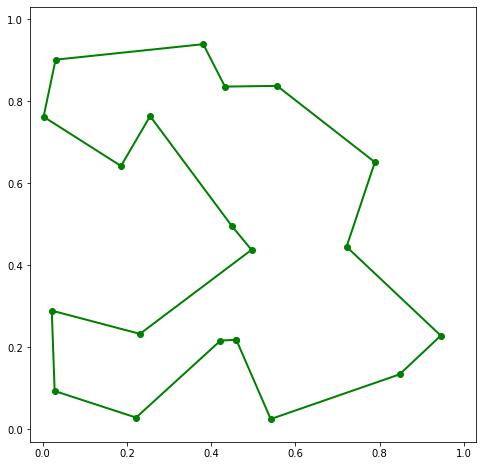

In [4]:
tsp = TSP(20)
ea = EvolutionaryAlgorithm(tsp)
solution = ea.optimize()
print(tsp.evaluate(solution))
tsp.display_solution_param(solution)

**Task 3:** Implement the QAP (https://en.wikipedia.org/wiki/Quadratic_assignment_problem). Use EA to solve it.

In [5]:
import numpy as np

class QAP():
    def __init__(self, distances, flows, seed=1):
        random.seed(seed)
        drows, dcols = distances.shape
        frows, fcols = flows.shape
        if drows != dcols or frows != fcols or drows != frows:
            raise ValueError("distances and flows must be square matrices of the same size")
        self.size = drows
        self.distances = distances
        self.flows = flows
                
    def random_solution(self):
        # facility -> location
        return np.random.permutation(self.size)
    
    def evaluate(self, solution):
        return sum(
            self.flows[f1, f2] * self.distances[solution[f1], solution[f2]]
            for f1 in range(self.size)
            for f2 in range(self.size)
        )
    
    def mutate(self, solution):
        mutated = np.copy(solution)
        i = random.randrange(self.size)
        j = random.randrange(self.size)
        mutated[i], mutated[j] = mutated[j], mutated[i]
        return mutated
    
    def crossover(self, a, b):
        cut = random.randrange(self.size)
        left_a = a[0:cut]
        left_b = b[0:cut]
        child1 = np.array(list(left_a) + [x for x in b if x not in left_a])
        child2 = np.array(list(left_b) + [x for x in a if x not in left_b])
        return child1, child2

In [6]:
distances = np.array([
    [0, 40, 64, 36, 22, 60],
    [40, 0, 41, 22, 36, 72],
    [64, 41, 0, 28, 44, 53],
    [36, 22, 28, 0, 20, 50],
    [22, 36, 44, 20, 0, 41],
    [60, 72, 53, 50, 41, 0]
])
flows = np.array([
    [0, 1, 1, 2, 0, 0],
    [1, 0, 0, 0, 0, 2],
    [1, 0, 0, 0, 0, 1],
    [2, 0, 0, 0, 3, 0],
    [0, 0, 0, 3, 0, 0],
    [0, 2, 1, 0, 0, 0]
])
# source: https://neos-guide.org/content/qap6
qap = QAP(distances, flows)
ea = EvolutionaryAlgorithm(qap)
solution = ea.optimize()
print(solution)
print(qap.evaluate(solution))

[3 1 5 4 0 2]
626


**Task 4:** Choose one of the problems (TSP or QAP). Assume a constant number of fitness evaluations per each evolutionary run. For a sufficiently big (nontrivial) problem:

a) Assume $N = 200$, $t = 5$. Prepare a heatmap illustrating the influence of values of $p_m$ and $p_c$ on the quality of the solution.

b) Assume $p_m = 0.5$, $p_c = 0.5$. Prepare a heatmap illustrating the influence of values of $N$ and $t$ on the quality of the solution.

Discuss the results. Can we expect to see similar results under different search termination conditions (e.g. a number of iterations with no improvement)? Can we expect to see similar results for different optimization problems?

In [9]:
import itertools

def param_grid(variable_params):
    keys = variable_params.keys()
    values_with_index = (enumerate(values) for values in variable_params.values())
    for params in itertools.product(*values_with_index):
        index, values = zip(*params)
        yield index, dict(zip(keys, values))

def evaluate(problem, **options):
    ea = EvolutionaryAlgorithm(problem, **options)
    solution = ea.optimize()
    return problem.evaluate(solution)

def experiment(problem, constants, variables, repetitions=10):
    keys = variables.keys()
    labels = tuple([f"{key}={value}" for value in variables[key]] for key in keys)
    dims = tuple(map(len, variables.values()))
    results = np.zeros(dims)
    for index, variable_values in param_grid(variables):
        results[index] = sum(
            evaluate(problem, **constants, **variable_values)
            for _ in range(repetitions)
        ) / repetitions
    return results, labels

def draw_heatmap(results, labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    y_labels, x_labels = labels 
    ax.set_xticks(list(range(len(x_labels))))
    ax.set_yticks(list(range(len(y_labels))))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    im = ax.imshow(results)
    fig.colorbar(im, ticks=np.linspace(0, 1, 6))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    for (row, column), value in np.ndenumerate(results):
        ax.text(column, row, f"{value:.04}", ha="center", va="center", color="w")
    plt.show()

In [10]:
heatmap1, labels1 = experiment(
    tsp,
    {
        'population_size': 200,
        'tournament_size': 5
    },
    {
        'crossover_prob': np.linspace(0.9, 0.1, 9),
        'mutation_prob': np.linspace(0.05, 0.5, 10),
    }
)

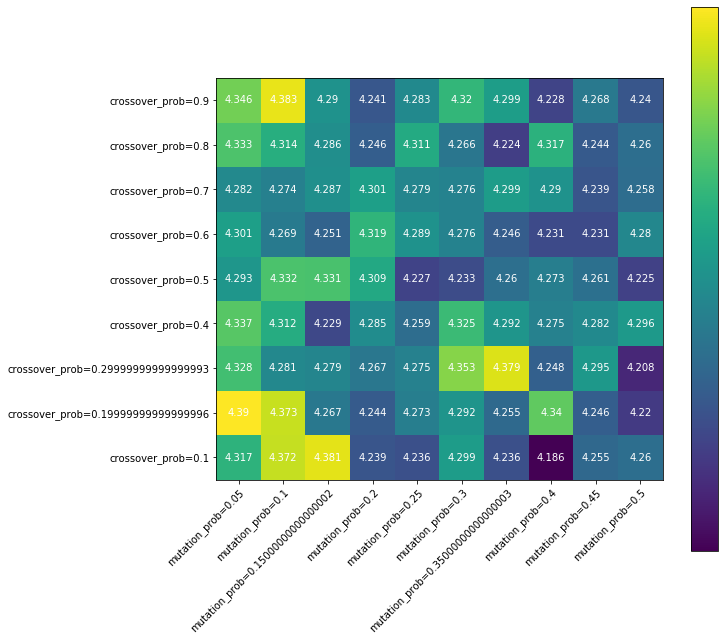

In [11]:
draw_heatmap(heatmap1, labels1)

In [12]:
heatmap2, labels2 = experiment(
    tsp,
    {
        'crossover_prob': 0.5,
        'mutation_prob': 0.5
    },
    {
        'population_size': [1000, 500, 200, 100, 50, 20],
        'tournament_size': [5, 8, 11, 14, 17, 20]
    }
)

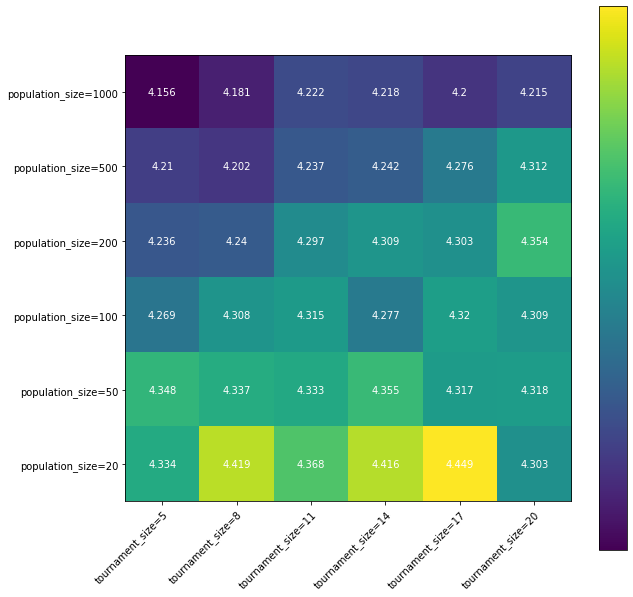

In [13]:
draw_heatmap(heatmap2, labels2)